# Forecasting taxi orders

## Project Description

The company "taksi" has collected historical data on taxi orders at airports. In order to attract more drivers during the peak period, we need to predict the number of taxi orders for the next hour. 

**Task:** 
- Build a model to predict taxi orders for the next hour.

**Important Criteria:**
- The value of the RMSE metric on the test sample should not be greater than 48.

**Plan of work:**
- Data loading and preparation
- Data analysis
- Data preparation and model training
- Summarising the results of the work

**Description of data - `taxi.csv` file**

- `datetime` - time 
- `num_orders` - number of orders (***target***)

## Data loading and preparation

Load the required libraries

In [1]:
%pip install statsmodels
%pip install --upgrade scikit-learn
%pip install lightgbm


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Import the required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

Settings

In [3]:
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

Save the file to a dataframe

In [4]:
try:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Taking a look at some general information about the dataframe

In [5]:
df.info()
print("\nIndex is monotonic:", df.index.is_monotonic_increasing or df.index.is_monotonic_decreasing)
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Index is monotonic: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


All data are sorted in order and sorted to date type. There are no gaps in the data either, as the number of rows is the same as the number of indices

Resample the dataframe one hour at a time

In [6]:
df = df.resample('1H').sum()
df


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Data analysis

Divide the data into trend, seasonal and noise components and plot the corresponding graphs

In [7]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Residuals')

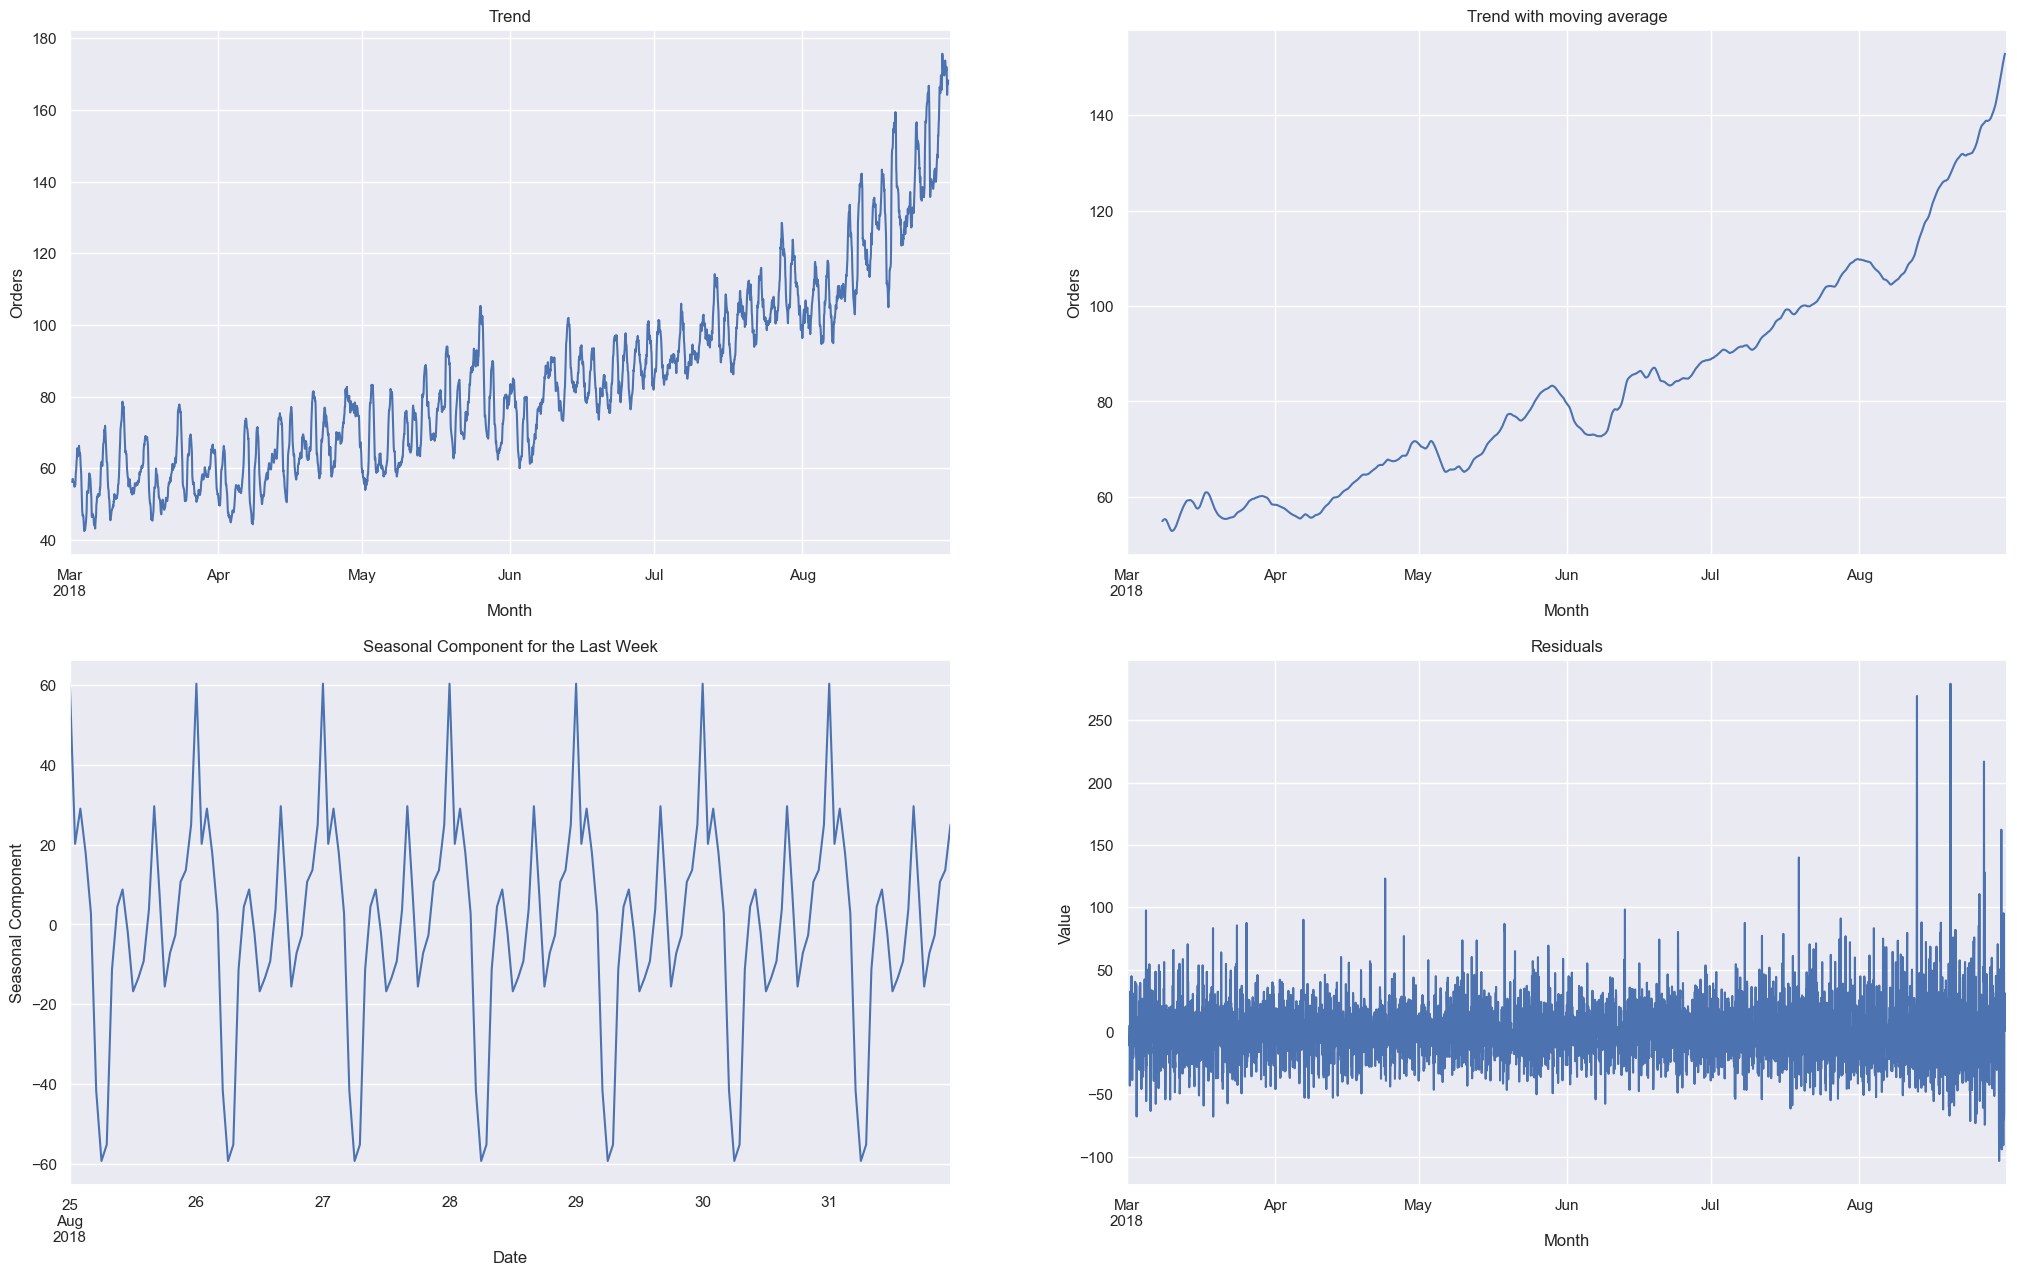

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))

ax[0, 0] = decomposed.trend.plot(ax=ax[0, 0])
ax[0, 0].set_ylabel('Orders')
ax[0, 0].set_xlabel('Month')
ax[0, 0].set_title('Trend')

ax[0, 1] = decomposed.trend.rolling(24 * 7).mean().plot(ax=ax[0, 1])
ax[0, 1].set_ylabel('Orders')
ax[0, 1].set_xlabel('Month')
ax[0, 1].set_title('Trend with moving average')


ax[1, 0] = decomposed.seasonal.tail(24 * 7).plot(ax=ax[1, 0])
ax[1, 0].set_ylabel('Seasonal Component')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_title('Seasonal Component for the Last Week')
ax[1, 0].grid(True)


ax[1, 1] = decomposed.resid.plot(ax=ax[1, 1])
ax[1, 1].set_ylabel('Value')
ax[1, 1].set_xlabel('Month')
ax[1, 1].set_title('Residuals')

Check the data for the presence of weekly seasonality (for this purpose we resample the data by days and change the investigated period)

In [9]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31'].resample("1D").sum())

Text(0.5, 1.0, 'Seasonal Component for the Last Month')

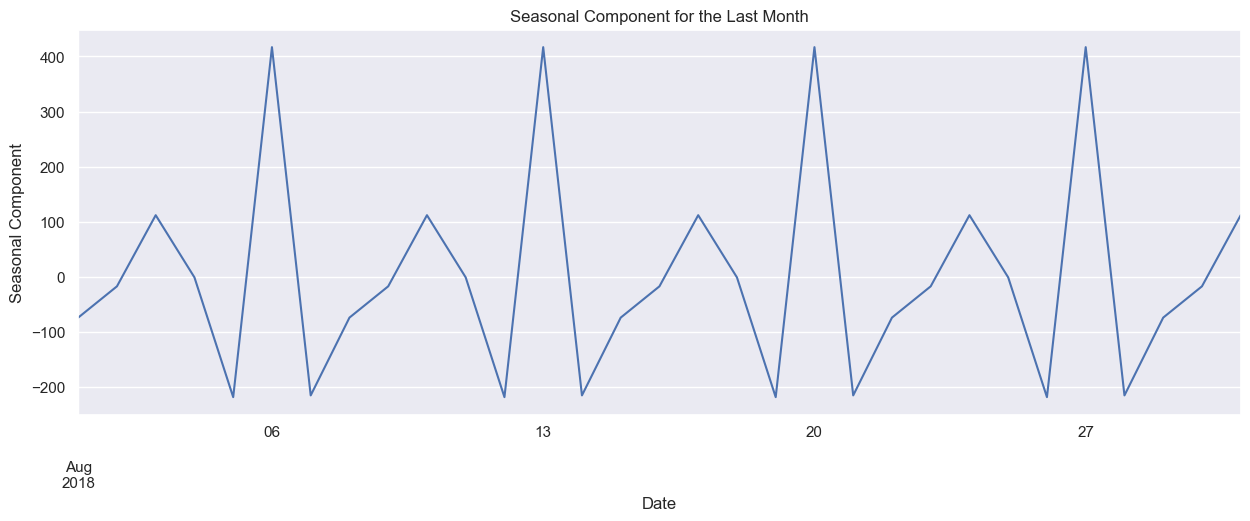

In [10]:
plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.ylabel('Seasonal Component')
plt.xlabel('Date')
plt.title('Seasonal Component for the Last Month')

The number of orders increases dramatically at weekly intervals

**Conclusions:**
- In the provided dataframe there is a trend of increasing number of orders;
- There is a daily seasonality: decrease in the number of orders at night, increase in the morning and afternoon, peak in the evening;
- There is weekly seasonality;
- The residuals are unexplained.

## Data preparation and model training

### Data preparation

Write a function to create additional attributes. Since we have identified weekly and daily seasonality, we need to add the day of the week and hour to each record. Also, we will add a moving average to the table

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag).copy()

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

Now let's add new attributes to the dataframe

In [12]:
df = make_features(df, 24*7, 24)
df

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,168.041667


We now split the data into samples in the proportion 9:1

In [13]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

df.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['num_orders']), # X
    df['num_orders'], # y
    shuffle=False,
    test_size=TEST_SIZE
)


In [14]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3823, 171)
X_test shape: (425, 171)
y_train shape: (3823,)
y_test shape: (425,)


### Metric

Since it is important for us to evaluate the `RMSE` metric - we need to specify it manually, as it is not built into the `scikit-learn` library.

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### LinearRegression

We will look at the metrics of the linear regression model on the cross-validation sample

In [16]:
param_grid = {}

As we are working with a time series, the usual cross-validation will not work for us. Instead, we will use `TimeSeriesSplit`. This way, we can take the time order into account when cross-validating

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
%%time
randomized_search = RandomizedSearchCV(LinearRegression(),
                                        param_grid, 
                                        cv=tscv,
                                        scoring=rmse_scorer,
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search.fit(X_train, y_train)
                             

CPU times: total: 15.6 ms
Wall time: 1.59 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={}, random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False))

In [20]:
results = pd.DataFrame(randomized_search.cv_results_)
linear_model_rmse = round(-randomized_search.best_score_, 2)

display(results[['mean_fit_time', 'mean_score_time', 'mean_test_score', 'rank_test_score']])
print('RMSE:', linear_model_rmse)


,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,0.027273,0.003417,-22.687125,1


RMSE: 22.69


On this amount of data, the model is trained quickly and its `RMSE' metric is 22.69

### LGBMRegressor

Create a list of parameters that we want to enumerate

In [21]:
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}


Looking for the best model metric and hyperparameters

In [22]:
%%time
randomized_search = RandomizedSearchCV(LGBMRegressor(random_state=RANDOM_STATE),
                                        param_grid, 
                                        cv=tscv,
                                        scoring=rmse_scorer,
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31587
[LightGBM] [Info] Number of data points in the train set: 3823, number of used features: 171
[LightGBM] [Info] Start training from score 79.561601
CPU times: total: 6.73 s
Wall time: 51.9 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [31, 50, 100]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False))

Output the result

In [23]:
results = pd.DataFrame(randomized_search.cv_results_)
lgbm_rmse = round(-randomized_search.best_score_, 2)

display(results[['mean_fit_time', 'mean_score_time', 'param_num_leaves', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head())
print('RMSE:', lgbm_rmse)


,mean_fit_time,mean_score_time,param_num_leaves,param_learning_rate,param_n_estimators,mean_test_score,rank_test_score
0,36.862517,0.011527,100,0.01,500,-22.970448,1
2,4.664219,0.011364,31,0.05,100,-23.059453,2
8,8.127621,0.009712,31,0.05,200,-23.123058,3
5,9.985648,0.010439,100,0.05,100,-23.163416,4
1,14.699530,0.013030,50,0.05,200,-23.225964,5


RMSE: 22.97


The best parameters of the model are `num_leaves` = 31; `learning_rate` = 0.05, `n_estimators` = 100. At these parameters the model is trained much faster than the others, but `RMSE` does not differ much from the best one. This model takes much longer to train than `LinearRegression`, and the `RMSE` metric of both models is almost the same

### DecisionTreeRegressor

Create a parameter grid for the model

In [24]:
param_grid = {
    'max_depth': [None, 10, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Looking for the best model metric and hyperparameters

In [25]:
%%time
randomized_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                                        param_grid, 
                                        cv=tscv,
                                        scoring=rmse_scorer,
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search.fit(X_train, y_train)

CPU times: total: 1.53 s
Wall time: 2.77 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 40],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False))

Output the result

In [26]:
results = pd.DataFrame(randomized_search.cv_results_)
dt_rmse = round(-randomized_search.best_score_, 2)

display(results[['mean_fit_time', 'mean_score_time', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head())
print('RMSE:', dt_rmse)


,mean_fit_time,mean_score_time,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
6,0.480674,0.007137,10,5,5,-30.500229,1
7,0.465992,0.006354,10,10,5,-30.500229,1
0,0.476263,0.006605,None,10,5,-31.260515,3
9,0.418669,0.003475,40,2,5,-31.260515,3
8,0.476562,0.004957,10,2,2,-31.767310,5


RMSE: 30.5


The best parameters for this model are `max_depth` = 10, `min_samples_split` = 10, `min_samples_leaf` = 5. With these parameters, the model is trained quite fast and has the highest `RMSE`. This model is trained almost like `LinearRegression`, but its `RMSE` is much higher than the others

### Check the best model on a test sample

So, the best model turned out to be `LinearRegression`. It learns faster than others and gives the most accurate results, so we will use it on the test data

In [30]:
best_model = LinearRegression()
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

RMSE: 34.36356789997796
R2: 0.6595648537336555


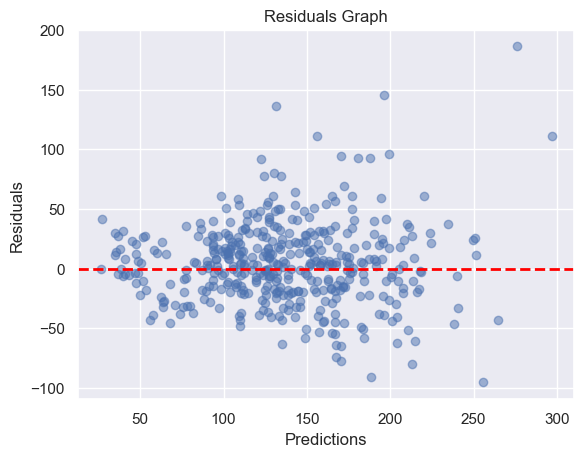

In [31]:
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')


plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals Graph')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

So, the model is highly erroneous, but `RMSE` on the test sample turned out to be 34.4, which is lower than the specified criterion (`RMSE` <= 48). The task can be considered as fulfilled

Just in case, let's check the `RMSE` metric obtained by predicting the previous series

In [32]:
y_pred_shifted = y_test.shift()
y_pred_shifted.iloc[0] = y_test.iloc[-1]

print('RMSE:', rmse(y_test, y_pred_shifted))

RMSE: 59.27241199351863


Our model does a much better job

### Prediction Analysis

Let's visualise the result of the model and compare it with the real values on the graph

Text(0.5, 1.0, 'Num Orders')

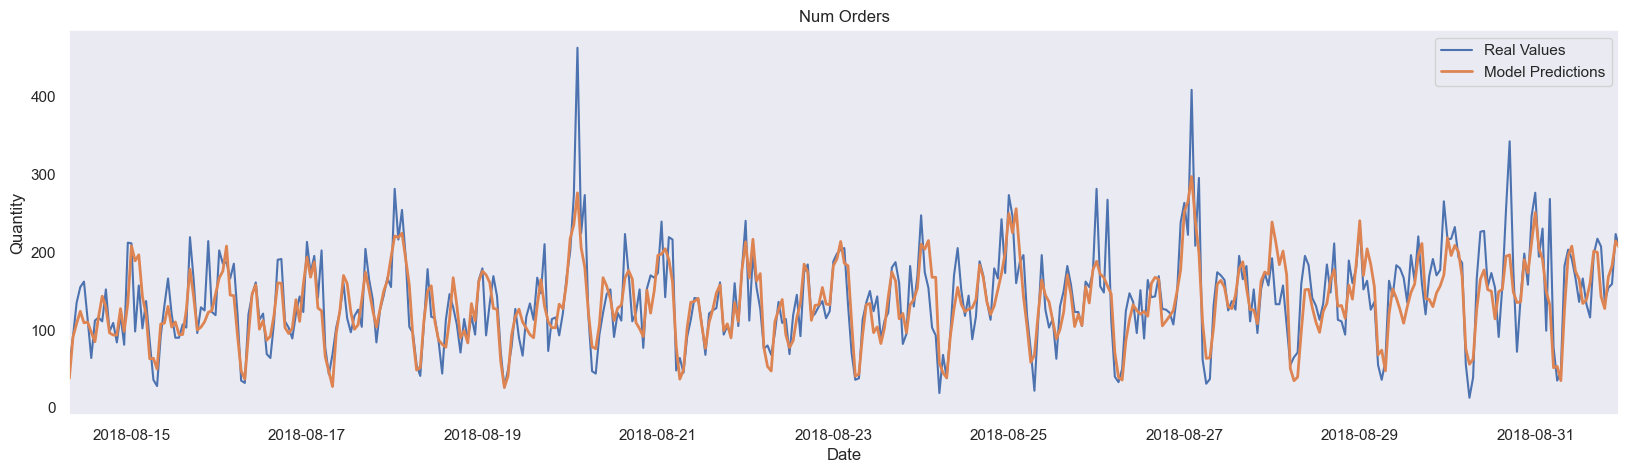

In [44]:
pred_linear = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(20,5))

# Lineplot with real values
sns.lineplot(y=y_test.values, x=y_test.index, label='Real Values')

# Lineplot with predicted values
sns.lineplot(y=pred_linear.values, x=pred_linear.index, linewidth=2, label='Model Predictions')

plt.grid()
plt.xlim(y_test.index.min(), y_test.index.max())
plt.legend()
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.title('Num Orders')

- The real values and model predictions have similar trends and patterns, indicating that the model approximates the data reasonably well;
- The model appears to be reasonably accurate as the line of predictions follows the line of real values. However, there are times when the model does not accurately predict spikes or dips, which is especially noticeable at large peaks.

## Conclusions

### Task Description

We were tasked with building a model that would be able to determine the number of taxi orders for the next hour.

Criteria that were important to the customer:
- The value of the RMSE metric on the test sample should not be greater than 48.

### Description of work steps

1. We downloaded the data and resampled it one hour at a time;
2. We analysed the data for trends and seasonal components: there is a trend for higher order values; there is daily seasonality; there is weekly seasonality;
4. Added new features to the data and split the data into samples;
6. Tested three models (`LinearRegression`, `LGBMRegressor`, `DecisionTreeRegressor`) and determined the best one (based on customer criteria).

### Final conclusion

We tested three models:

- `LinearRegression` - the model's `RMSE` metric was 22.69; this model has a training time of 0.03 seconds and a prediction rate of 0.003 seconds

- `LGBMegressor` (`num_leaves` = 31; `learning_rate` = 0.05, `n_estimators` = 100) - the model's `RMSE` metric was 23.06; this model has a training time of 4.66 seconds and a prediction rate of 0.01 seconds

- `DecisionTreeRegressor` (`max_depth` = 10, `min_samples_split` = 10, `min_samples_leaf` = 5) - the `RMSE` metric of the model was 30.5; the training time of such a model is 0.47 seconds and the prediction speed is 0.006 seconds
	
So, the best model is `LinearRegression` as its `RMSE` metric is the lowest, and the model is trained and makes predictions in the shortest time. Thus, it should be used for ordering. Also, we checked the metrics of the model on the test sample: `RMSE` of the model is 34.4, which passes the customer's criterion (`RMSE` <= 48).